### Stock Market Prediction And Forecasting Using Stacked LSTM

### Import the Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
import datetime
import plotly
import cufflinks as cf
cf.go_offline()
%matplotlib inline

/Users/siddhantgolangade/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Set Duration

In [2]:
start = datetime.datetime(2017, 7, 12)
end = datetime.datetime(2020, 7, 12)

### Import the data using DataReader

In [3]:
df = data.DataReader("BTC-USD",'yahoo',start,end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-07-10,2413.469971,2296.810059,2385.889893,2337.790039,1.329760e+09,2337.790039
2017-07-11,2423.709961,2275.139893,2332.770020,2398.840088,1.117410e+09,2398.840088
2017-07-12,2425.219971,2340.830078,2402.699951,2357.899902,8.357700e+08,2357.899902
2017-07-13,2363.250000,2183.219971,2360.590088,2233.340088,8.825030e+08,2233.340088
2017-07-14,2231.139893,1990.410034,2230.120117,1998.859985,9.936080e+08,1998.859985


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-06,9360.617188,9201.815430,9349.161133,9252.277344,1.383965e+10,9252.277344
2020-07-07,9450.335938,9249.500000,9253.020508,9428.333008,1.970236e+10,9428.333008
2020-07-08,9431.378906,9234.999023,9427.994141,9277.967773,1.800070e+10,9277.967773
2020-07-09,9287.471680,9118.001953,9273.357422,9278.807617,1.686004e+10,9278.807617
2020-07-10,9293.532227,9199.485352,9277.511719,9240.346680,1.324991e+10,9240.346680


### Exploratory Data Analysis

#### Maximum Closing Rate

In [5]:
df.xs(key='Close',axis=1).max()

19497.400390625

#### Visualization (Closing Rate)

In [6]:
df.xs(key='Close',axis=1).iplot()

#### 30-day Moving Average for Close Price

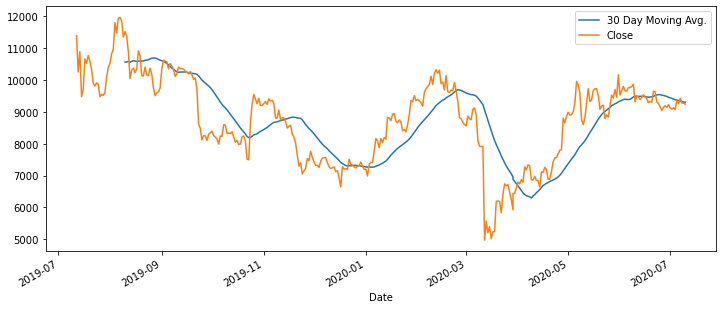

In [43]:
plt.figure(figsize=(12,5))
df['Close'].loc['2019-07-12':'2020-07-12'].rolling(window=30).mean().plot(label='30 Day Moving Avg.')
df['Close'].loc['2019-07-12':'2020-07-12'].plot(label='Close')
plt.legend()

In [44]:
df0 = df[['Open','High','Low','Close']].loc['2019-07-12':'2020-07-12']
df0.iplot(kind='candle')

In [9]:
df['Close'].loc['2019-07-10':'2020-07-10'].ta_plot(study='sma',periods=[9,18,27])

#### Let's Reset the Index to Close

In [10]:
df1=df.reset_index()['Close']

In [11]:
df1

0       2337.790039
1       2398.840088
2       2357.899902
3       2233.340088
4       1998.859985
           ...     
1092    9252.277344
1093    9428.333008
1094    9277.967773
1095    9278.807617
1096    9240.346680
Name: Close, Length: 1097, dtype: float64

#### Using MinMaxScaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)

[[0.0232229 ]
 [0.02669805]
 [0.02436761]
 ...
 [0.41827888]
 [0.41832668]
 [0.41613737]]


#### Splitting the Close data into Train and Test sets

In [14]:
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(767, 330)

In [16]:
train_data

array([[0.0232229 ],
       [0.02669805],
       [0.02436761],
       [0.01727729],
       [0.00392997],
       [0.        ],
       [0.01699665],
       [0.02214647],
       [0.01955932],
       [0.05053514],
       [0.04200579],
       [0.05010936],
       [0.04557144],
       [0.04696379],
       [0.03680985],
       [0.03413276],
       [0.04223462],
       [0.05004617],
       [0.0453466 ],
       [0.04709584],
       [0.05382188],
       [0.0448804 ],
       [0.04444835],
       [0.04980253],
       [0.05499163],
       [0.0753143 ],
       [0.07309601],
       [0.08248831],
       [0.08482215],
       [0.08041233],
       [0.08262151],
       [0.09795317],
       [0.11127827],
       [0.12201111],
       [0.13634831],
       [0.12819695],
       [0.13927985],
       [0.13672173],
       [0.12698392],
       [0.12886694],
       [0.1228308 ],
       [0.11793998],
       [0.12356284],
       [0.12646591],
       [0.13689194],
       [0.13899354],
       [0.1379006 ],
       [0.139

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)

(666, 100)
(666,)


(None, None)

In [20]:
print(X_test.shape), print(y_test.shape)

(229, 100)
(229,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Stacked LSTM Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 190ms/step - loss: 0.0506 - val_loss: 0.0039
Epoch 2/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0113 - val_loss: 0.0028
Epoch 3/100
11/11 [==============================] - 1s 99ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 4/100
11/11 [==============================] - 1s 99ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 5/100
11/11 [==============================] - 1s 99ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 6/100
11/11 [==============================] - 1s 98ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 7/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 8/100
11/11 [==============================] - 1s 99ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 9/100
11/11 [==============================] - 1s 97ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 10/100
11/11 [==============================] - 1s 96ms/step - loss: 0.0042 - val_loss: 0.0

### Lets Predict

In [27]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [28]:
# Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [29]:
### Calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

8182.6067878973045

In [30]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

8402.094161420711

### Let's Visualize the Predictions

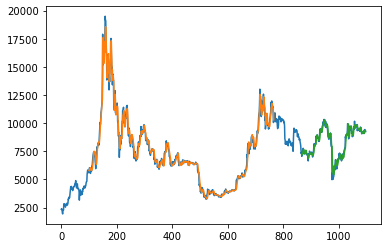

In [31]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(test_data)

330

In [33]:
x_input=test_data[230:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
temp_input

[0.2734336282655778,
 0.28106929198966224,
 0.2767204888371267,
 0.3040806513245977,
 0.29865208934812487,
 0.3076279458999638,
 0.30580588067902037,
 0.2809535003077089,
 0.28058861475785696,
 0.28696449500029597,
 0.2797891073811437,
 0.2796405460417197,
 0.2682378448143952,
 0.29525888720788823,
 0.29408515534586066,
 0.30327711375252125,
 0.29939267248918255,
 0.2818907569824924,
 0.2817976733668271,
 0.2952818454242333,
 0.3130712667298013,
 0.3199689877856522,
 0.3210525266548957,
 0.3273101415092619,
 0.3338980656167086,
 0.3345502624042829,
 0.3911305920254844,
 0.38301994893200486,
 0.3947582125636073,
 0.4018069964594525,
 0.3966197181102089,
 0.39748412552949564,
 0.4026308795695006,
 0.417754840839629,
 0.4566194322442826,
 0.4504232153316914,
 0.43626249854782684,
 0.3885914021799424,
 0.37978912197323034,
 0.3913263761367852,
 0.4178246049110891,
 0.44422177306235344,
 0.42113809256648604,
 0.4239168705777596,
 0.4406366224450238,
 0.44381497348072385,
 0.4439551686904628

In [36]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.41570956]
101
1 day input [0.28106929 0.27672049 0.30408065 0.29865209 0.30762795 0.30580588
 0.2809535  0.28058861 0.2869645  0.27978911 0.27964055 0.26823784
 0.29525889 0.29408516 0.30327711 0.29939267 0.28189076 0.28179767
 0.29528185 0.31307127 0.31996899 0.32105253 0.32731014 0.33389807
 0.33455026 0.39113059 0.38301995 0.39475821 0.401807   0.39661972
 0.39748413 0.40263088 0.41775484 0.45661943 0.45042322 0.4362625
 0.3885914  0.37978912 0.39132638 0.4178246  0.44422177 0.42113809
 0.42391687 0.44063662 0.44381497 0.44395517 0.4322258  0.40711023
 0.41284895 0.41436937 0.39052323 0.39715854 0.39306681 0.41276018
 0.43238345 0.42745238 0.4423258  0.42870096 0.46890058 0.43261414
 0.43983848 0.44803078 0.44034028 0.43966554 0.4456523  0.44637162
 0.44774978 0.45198454 0.42077287 0.42982719 0.42951034 0.42447326
 0.42811144 0.43308209 0.42979367 0.42589934 0.418851   0.42137396
 0.41973964 0.43938309 0.43829816 0.42030776 0.41753009 0.41172989
 0.40503988 0.41062923 0.41332013 

### Predictions for Next 30 Days

In [37]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [38]:
len(df1)

1097

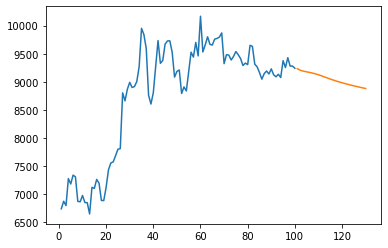

In [46]:
plt.plot(day_new,scaler.inverse_transform(df1[997:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [48]:
df3=scaler.inverse_transform(df3).tolist()

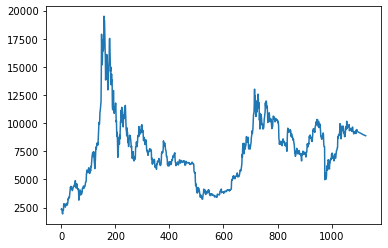

In [49]:
plt.plot(df3)

**CONCLUSION:** Here, these predictions say that 